In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pyscf
from pyscf import gto,scf,fci,lo,mcscf
from pyscf import ao2mo
from pyscf.tools import molden

/home/zbwu/soft/anaconda3/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
molname = 'hplane34'
natoms = 6
r = 1.0

mol = gto.Mole()
mol.verbose = 0

if molname == 'hchain':
    mol.atom = [['H',(0.0,0.0,i*r)] for i in range(natoms)]

elif molname == 'hplane':
    mol.atom = [['H',(0.,0.,0.)],
                ['H',(0.,0.,r)],
                ['H',(0.,0.,2*r)],
                ['H',(0.,r,0)],
                ['H',(0.,r,r)],
                ['H',(0.,r,2*r)]]

elif molname == 'hplane34':
    atom = []
    for i in range(3):
        for j in range(4):
            x = i * 4.0
            y = j * 4.0
            atom += [['H', (x, y, 0)]]
    mol.atom = atom
    mol.unit='bohr'
    
elif molname == 'hplane44':
    atom = []
    for i in range(4):
        for j in range(4):
            x = i * 4.0
            y = j * 4.0
            atom += [['H', (x, y, 0)]]
    mol.atom = atom
    mol.unit='bohr'

elif molname == 'n2':
    mol.atom = [['N',(0.,0.,0.)],
                ['N',(0.,0.,r)]]

elif molname == 'hf':
    mol.atom = [['H',(0.,0.,0.)],
                ['F',(0.,0.,r)]]

elif molname == 'c2':
    mol.atom = [['C',(0.,0.,0.)],
                ['C',(0.,0.,r)]]

mol.verbose = 5
mol.basis = 'sto-3g' 
mol.symmetry = True 
mol.charge = 0
mol.spin = 0
mol.build()

mf = scf.RHF(mol)
mf.init_guess = 'atom'
mf.level_shift = 0.0
mf.max_cycle = 100
mf.conv_tol=1.e-14
mf.scf()

System: uname_result(system='Linux', node='myarch', release='6.6.32-1-lts', version='#1 SMP PREEMPT_DYNAMIC Sat, 25 May 2024 20:20:51 +0000', machine='x86_64')  Threads 4
Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy 1.24.0  scipy 1.10.1
Date: Tue Jun  4 11:52:32 2024
PySCF version 2.4.0
PySCF path  /home/zbwu/soft/anaconda3/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 12
[INPUT] num. electrons = 12
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry True subgroup None
[INPUT] Mole.unit = bohr
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 H      0.000000000000   2.116708843680   0.000000000000 AA    0.000000000000   4.000000000000 

-4.623286002670964

In [3]:
mf.mo_energy

array([-0.37227196, -0.30796687, -0.28762573, -0.2017893 , -0.20114304,
       -0.16800581,  0.0216693 ,  0.03506123,  0.06003947,  0.13197478,
        0.14067011,  0.21844266])

In [4]:
# from pyscf import mcscf, mrpt

# mc = mcscf.CASSCF(mf,4,4)
# ecas = mc.kernel()[0]
# ept2 = mrpt.NEVPT(mc).kernel()
# ecas, ecas + ept2

In [5]:
# mc = mcscf.CASSCF(mf,12,12)
# ecas = mc.kernel()[0]
# ept2 = mrpt.NEVPT(mc).kernel()
# ecas, ecas + ept2

In [6]:
# from pyscf import cc
# mycc = cc.CCSD(mf).run()
# print('CCSD total energy', mycc.e_tot)
# et = mycc.ccsd_t()
# print('CCSD(T) total energy', mycc.e_tot + et)

In [7]:
mo = 'oao'
if mo == 'cmo':
    mo_coeff = mf.mo_coeff
elif mo == 'oao':
    mo_coeff = lo.orth_ao(mol, method="meta-lowdin")
molden.from_mo(mol, 'mo.molden', mo_coeff)

norb = mo_coeff.shape[1]
h1 = mo_coeff.T.dot(mf.get_hcore()).dot(mo_coeff)
eri = ao2mo.kernel(mol, mo_coeff)

irreps of each MO ['Ag' 'B2u' 'Ag' 'B2u' 'Ag' 'B3u' 'B3u' 'Ag' 'B3u' 'B1g' 'B3u' 'B1g']

WARN: orbitals [ 0  1  2  3  4  5  6  7  8  9 10 11] not symmetrized, norm = [0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5  0.25 0.25 0.25 0.25]



In [8]:
# #
# # FCI
# #

# cisolver = fci.direct_spin1.FCI(mol)
# cisolver = pyscf.fci.addons.fix_spin(cisolver,shift=0.05,ss=0)
# cisolver.nroots = 2 #10
# norb = mol.nao
# nelec = [mol.nelectron//2,mol.nelectron//2]
# e, ci = cisolver.kernel(h1, eri, norb, nelec, ecore=mol.energy_nuc(), max_cycle=1000)
# e

In [9]:
eri = ao2mo.general(mol,(mo_coeff,mo_coeff,mo_coeff,mo_coeff),compact=0).reshape(norb,norb,norb,norb)

In [10]:
kij = np.einsum('ijji->ij',eri)

# 1. generate a 1D ordering

In [11]:
# import utils.graph.fielder
from utils.graph import fielder

forder = fielder.orbitalOrdering(kij,mode='kmat',debug=False)
forder

array([ 8,  0,  4,  9,  1,  5,  6, 10,  2,  7, 11,  3])

In [12]:
from utils.graph import greedy

gorder0 = greedy.greedyOrdering(kij,iwt=0)[-1]
gorder1 = greedy.greedyOrdering(kij,iwt=1)[-1]

print(gorder0)
print(gorder1)

[5, 6, 7, 3, 2, 1, 0, 4, 8, 9, 10, 11]
[1, 2, 6, 5, 0, 4, 9, 8, 10, 7, 3, 11]


# 2. add connections to other sites based on weights on graph

In [13]:
from utils.graph import nxutils

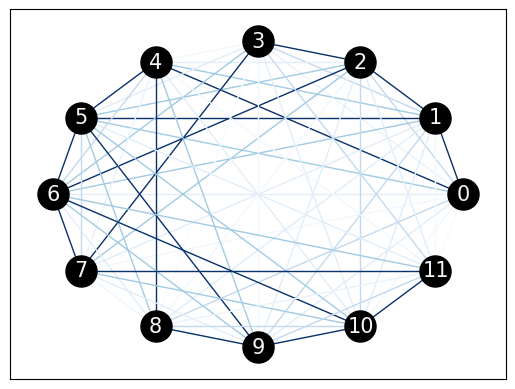

0

In [14]:
graph0 = nxutils.fromKijToGraph(kij)
nxutils.displayGraph(graph0,kij)

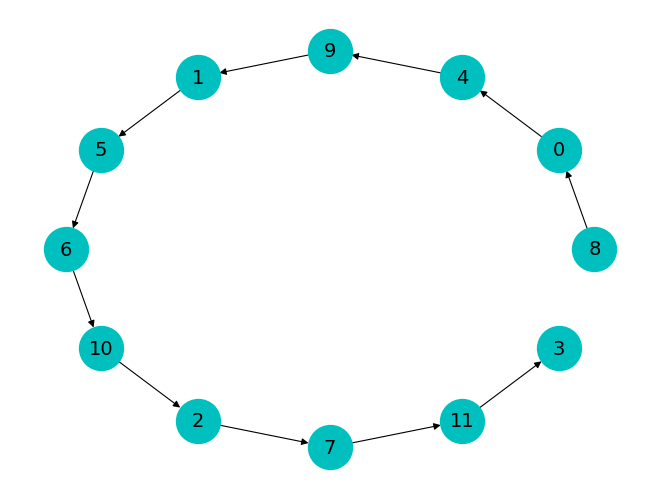

In [15]:
fgraph = nxutils.fromOrderToDiGraph(forder)
nxutils.displayCircular(fgraph)

In [16]:
import networkx

networkx.__version__

'3.3'

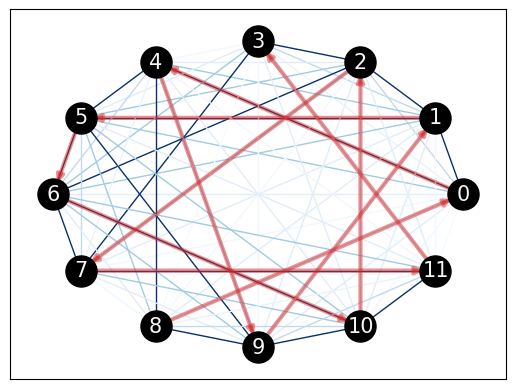

0

In [17]:
nxutils.displayGraphHighlight(graph0,kij,fgraph)

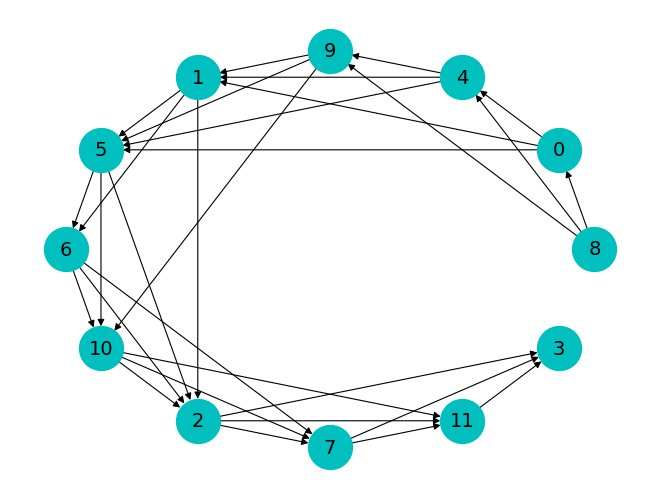

In [18]:
maxdes = 2
fgraph2 = nxutils.addEdgesByGreedySearch(fgraph,kij,maxdes)
nxutils.displayCircular(fgraph2)

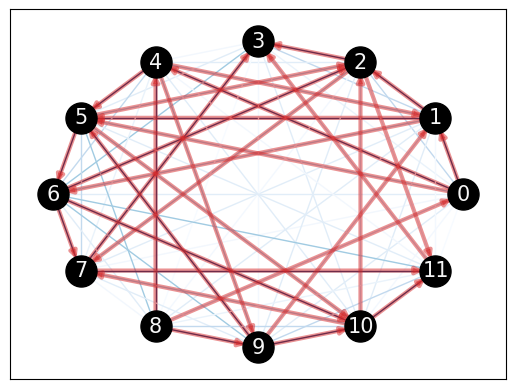

0

In [19]:
nxutils.displayGraphHighlight(graph0,kij,fgraph2)

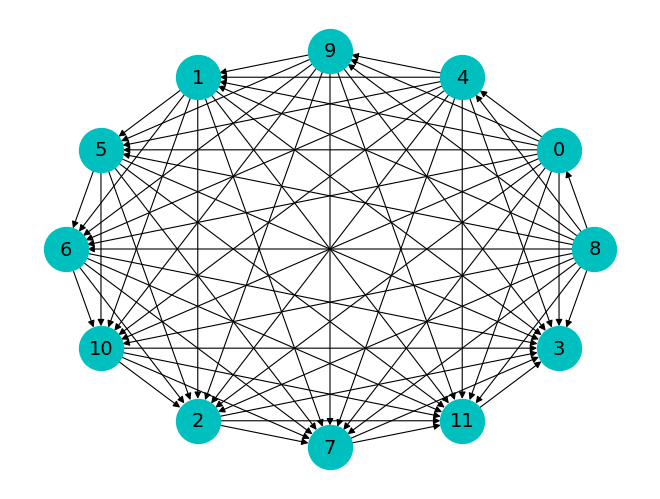

In [20]:
maxdes = len(graph0.nodes)-1
graph2 = nxutils.addEdgesByGreedySearch(fgraph,kij,maxdes)
nxutils.displayCircular(graph2)

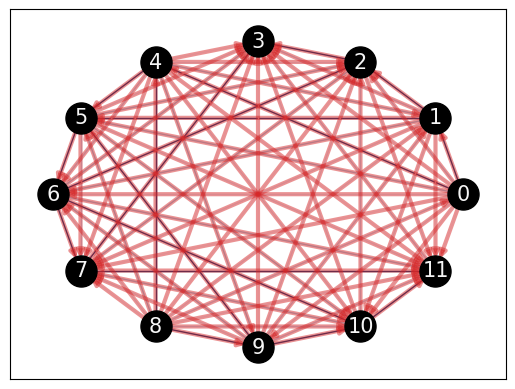

0

In [21]:
nxutils.displayGraphHighlight(graph0,kij,graph2)

# greedy

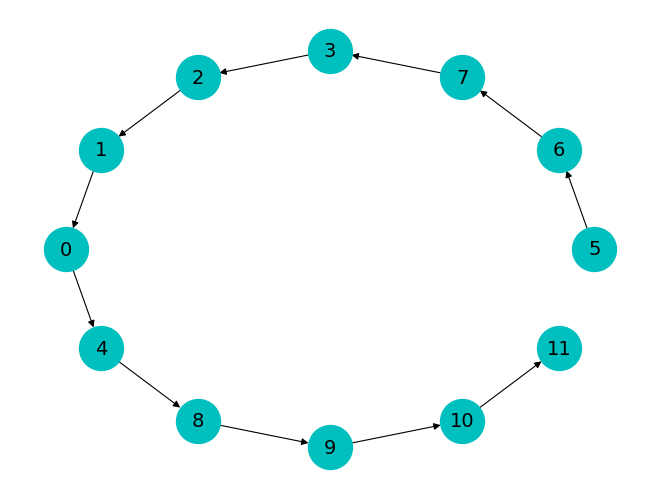

In [22]:
graph = nxutils.fromOrderToDiGraph(gorder0)
nxutils.displayCircular(graph)

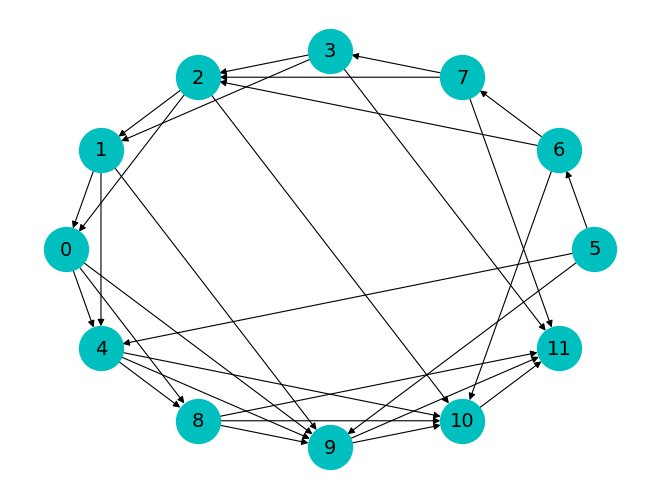

In [23]:
maxdes = 2
graph2 = nxutils.addEdgesByGreedySearch(graph,kij,maxdes)
nxutils.displayCircular(graph2)

# User defined graph

In [24]:
import networkx as nx

# define the geomtry of lattice

edges = [[0,1],[1,2],[2,3],
                      [0,4],[1,5],[2,6],[3,7],
                      [4,5],[5,6],[6,7],
                      [4,8],[5,9],[6,10],[7,11],
                     [8,9],[9,10],[10,11],
                      [8,12],[9,13],[10,14],[11,15],
                     [12,13],[13,14],[14,15]
                     ]
tij = np.zeros((16,16))
for i,j in edges:
    tij[i,j] = 1
    tij[j,i] = 1

In [25]:
graph = nx.Graph()
graph.add_edges_from(edges)
nnodes = len(graph.nodes)

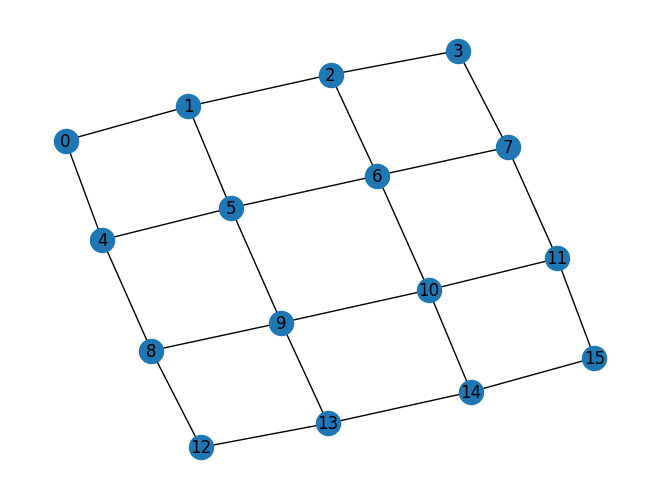

In [26]:
nx.draw_spring(graph, labels=dict(zip(range(nnodes),range(nnodes))))

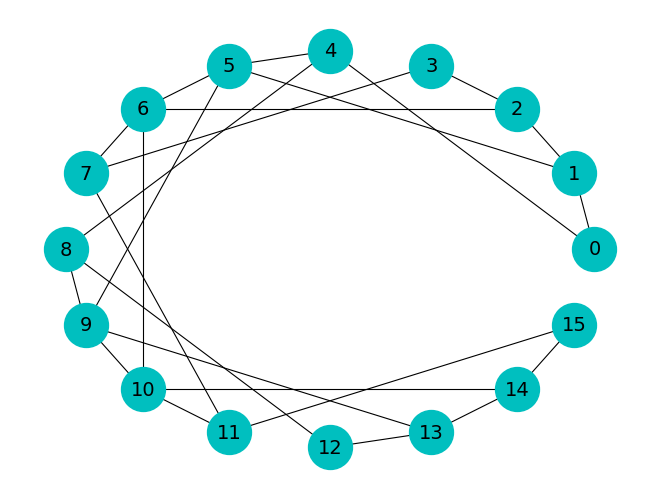

In [27]:
nxutils.displayCircular(graph)

forder= [ 8  0  4  9  1  5  6 10  2  7 11  3]


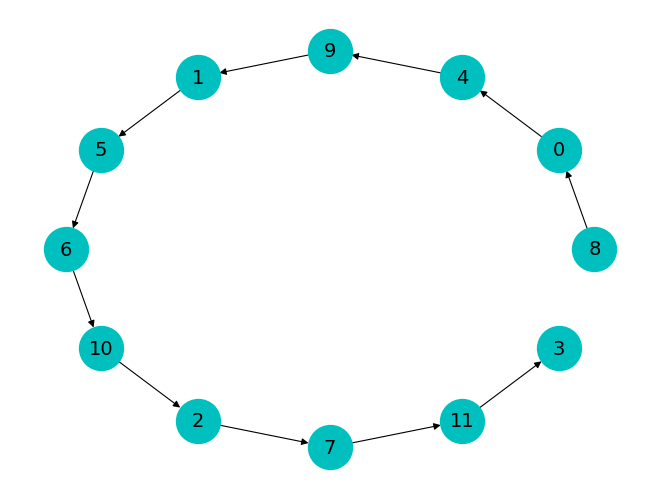

In [28]:
forder = fielder.orbitalOrdering(kij,'kmat')
print('forder=',forder)
fgraph = nxutils.fromOrderToDiGraph(forder)
nxutils.displayCircular(fgraph)

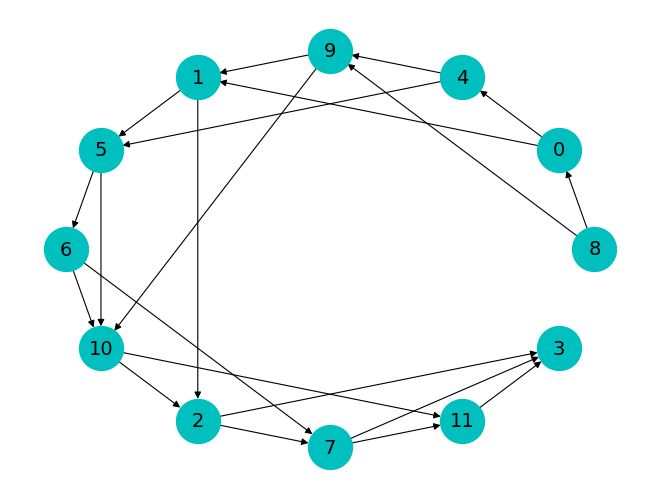

In [29]:
maxdes = 1
fgraph2 = nxutils.addEdgesByGreedySearch(fgraph,kij,maxdes)
nxutils.displayCircular(fgraph2)

# Highlight path on graph

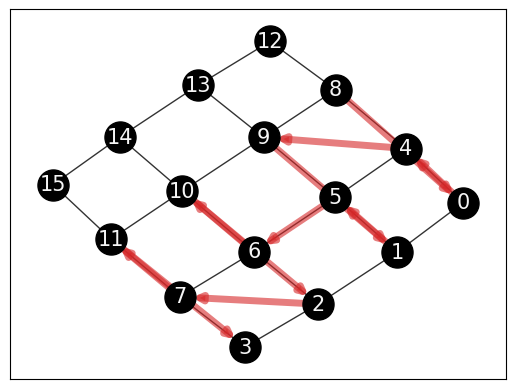

In [30]:
pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='black')
labels = dict(zip(graph.nodes,graph.nodes))
nx.draw_networkx_labels(graph, pos, labels, font_size=15, font_color="whitesmoke")
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.8)
nx.draw_networkx_edges(
    fgraph,
    pos,
    edgelist=list(fgraph.edges),
    edge_color="tab:red",
    width=5,
    alpha=0.6,
)
plt.show()

edgecomplement= [(8, 9), (0, 1), (4, 5), (9, 10), (1, 2), (5, 10), (6, 7), (10, 11), (2, 3), (7, 3)]


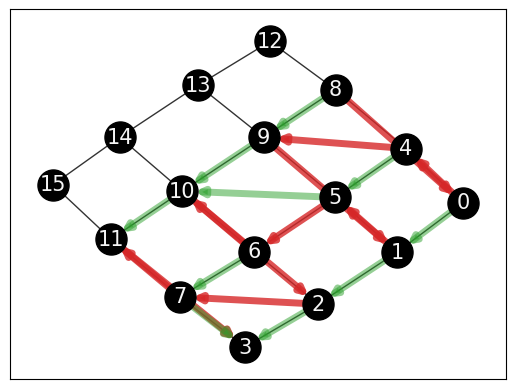

In [31]:
pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='black')
labels = dict(zip(graph.nodes,graph.nodes))
nx.draw_networkx_labels(graph, pos, labels, font_size=15, font_color="whitesmoke")
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.8)
nx.draw_networkx_edges(
    fgraph,
    pos,
    edgelist=list(fgraph.edges),
    edge_color="tab:red",
    width=5,
    alpha=0.8,
)
edgecomplement = [edge for edge in list(fgraph2.edges) if (edge[0],edge[1]) not in list(fgraph.edges) and (edge[1],edge[0]) not in list(fgraph.edges)]
print('edgecomplement=',edgecomplement)
nx.draw_networkx_edges(
    fgraph2,
    pos,
    edgelist=edgecomplement,
    edge_color="tab:green",
    width=5,
    alpha=0.5,
)
plt.show()